# Chap04 - Word2Vec 속도 개선

[Chap03](https://github.com/ExcelsiorCJH/DLFromScratch2/tree/master/Chap03-Word2Vec)에서 살펴본 CBOW 모델의 구조는 다음과 같은 문제가 있다.

- 말뭉치(corpus)에 포함된 어휘 수가 많아지면 계산량이 커진다.

이를 해결하기 위해 이번 장에서는 두 가지 개선을 추가한다.

1. `Embedding` 레이어를 도입한다.
2. 네거티브 샘플링(NEG, Negative Sampling)이라는 새로운 손실함수를 도입한다.

## 4.1 Word2Vec 개선 ①

[Chap03](https://github.com/ExcelsiorCJH/DLFromScratch2/tree/master/Chap03-Word2Vec)에서 구현한 CBOW 모델의 문제점은 아래의 그림에서 확인할 수 있듯이 예를 들어, 어휘가 100만개, 은닉층의 뉴런이 100개인 CBOW 모델의 경우에는 다음의 두 계산이 병목(bottleneck)이 된다.

- 입력층의 원핫(one-hot) 표현과 가중치 행렬 $\mathbf{W}_{\text{in}}$의 곱 계산

- 은닉층과 가중치 행렬 $\mathbf{W}_{\text{out}}$의 곱 및 `Softmax`(특히 분모)의 계산

<img src="./images/cbow_big.png" width="65%" height="65%" />

### 4.1.1 Embedding 계층

각 단어(어휘)를 원핫 표현으로 변환한 다음 가중치 행렬을 곱해주는 작업은 **결과적으로 단지 각 단어에 해당하는 특정 행을 추출**하는 것 뿐이다. 따라서, 원핫 표현으로의 변환과 가중치 행렬 곱 계산은 사실상 필요하지 않다.

![](./images/embedding.png)

### 4.1.2 Embedding 계층 구현

In [2]:
import numpy as np

W = np.arange(21).reshape(7, 3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [3]:
# 두 번째 행 가져오기
# -> index=2에 해당하는 단어 벡터
W[2]

array([6, 7, 8])

In [4]:
W[5]

array([15, 16, 17])

In [5]:
# 가중치 W로 부터 여러행을 
# 한꺼번에 추출하는 예제
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [7]:
# Embedding Layer 구현
# commons/layers.py
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

## 4.2 Word2Vec 개선 ②

4.1에서는 `Input - hidden`의 병목을 `Embedding`이라는 새로운 레이어를 도입해주면서 해결했고, 이번에는 `hidden - output`의 병목을 **Negative Sampling**을 통해 해결한다.

### 4.2.1 은닉층 이후 계산의 문제점

아래의 그림처럼 100만개의 단어에 대해 Softmax를 구하게 되면 계산량이 많아지는 문제가 있다.


$$
y_k = \frac{\exp{(s_k)}}{\sum_{i=1}^{1000000}{\exp{(s_i)}}}
$$

<img src="./images/cbow_big2.png" width="50%" height="50%" />

### 4.2.2 다중 분류에서 이진 분류로

Negative Sampling(NEG)의 핵심 아이디어는 **'이진 분류'**<sup>binary classificaton</sup>에 있다. 즉, '다중 분류<sup>multi-class classification</sup>'를 '이진 분류'로 근사하는 것이 Negative Sampling을 이해하는 데 중요한 포인트다.

![](./images/neg.png)

### 4.2.3 시그모이드 함수와 교차 엔트로피 오차

다중 분류의 경우에는 출력층에서 점수<sup>score</sup>를 확률로 변환할 때, 소프트맥스 함수를 사용하고, 이진 분류의 경우에는 시그모이드 함수를 사용한다. 


$$
y = \frac{1}{1 + \exp{(-x)}}
$$

시그모이드 함수를 적용해 확률 $y$를 구한 후, 이 확률 $y$로 부터 손실(Loss)을 구한다.


$$
L = - \left[ t \log{y} + (1-t) \log{(1-y)} \right]
$$

'Sigmoid with Loss' 레이어의 역전파를 구하면 다음과 같다.

$$
\begin{align*}
\frac{\partial L}{\partial x} &= \frac{\partial L}{\partial y} \frac{\partial y}{\partial x} = y-t \\
\frac{\partial L}{\partial y} &= -\frac{t}{y} + \frac{1-t}{1-y} = \frac{y-t}{y(1-y)} \\
\frac{\partial y}{\partial x} &= y(1-y)
\end{align*}
$$

<img src="./images/sigmoid02.png" width="70%" height="70%" />

위의 식에서 'Sigmoid with Loss'레이어에서의 역전파는 $y-t$ 즉, 오차가 앞의 계층으로 흘러가게 된다. 따라서, 오차가 크면 '크게'학습하고, 오차가 작으면 '작게'학습하게 된다.

### 4.2.4 다중 분류에서 이진 분류로(구현)

![](./images/cbow.png)

In [1]:
# Chap04/negative_sampling_layer.py
import sys
sys.path.append('..')
import collections
from common.np import *
from common.layers import Embedding, SigmoidWithLoss

In [9]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

### 4.2.5 네거티브 샘플링

다중 분류 문제를 이진 분류로 바꾸면서 `(입력, 타깃)`의 정답인 예제와 오답(`window_size`내에 포함 되어 있지 않은 단어 쌍)인 네거티브 샘플을 사용한다. 여기서 네거티브 샘플은 모든 단어에 대한 네거티브 샘플이 아니라 몇 개(5개 또는 10개) 정도를 선택하여, 즉 샘플링해 사용한다. 

Word2Vec의 학습 단계에서는 정답 데이터 쌍에 대해서는 1에 가깝게 예측하도록 학습하고, 오답(네거티브 샘플) 데이터 쌍에 대해서는 0에 가깝게 예측하도록 학습한다.

### 4.1.6 네거티브 샘플링의 샘플링 기법

네거티브 샘플링 방법에는 단순히 랜덤하게 샘플링하는 것이 아니라, 말뭉치(corpus)에서 각 단어에 대한 확률분포로 단어를 샘플링한다. 확률분포에서 샘플링하기 때문에 말뭉치에서 자주 등장하는 단어는 샘플링 될 가능성이 높고, '희소한 단어'는 선택되기 어렵다. '희소한 단어'는 실제로 많이 등장하는 단어가 아니기 때문에 이러한 드문 단어를 잘 처리하는 것은 중요하지 않으며, 차라리 흔한 단어를 잘 처리하는 편이 결과가 더 좋다.

![](./images/neg2.png)

In [2]:
# 확률분포에 따른 샘플링 예제
import numpy as np

# 0에서 9까지의 숫자 중 하나를 랜덤하게 샘플링
np.random.choice(10)

3

In [3]:
np.random.choice(10)

6

In [4]:
# words에서 하나만 무작위로 샘플링
words = ['you', 'say', 'goodbye', 'i', 'hello', '.']
np.random.choice(words)

'hello'

In [5]:
# 5개만 무작위로 샘플링(중복 없음)
np.random.choice(words, size=5, replace=False)

array(['goodbye', 'you', 'hello', 'i', '.'], dtype='<U7')

In [6]:
# 확률분포에 따라 샘플링
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

'you'

#### Word2Vec에서의 네거티브 샘플링

Word2Vec에서의 확률분포는 기본 확률분포(Unigram Distribution)에 $\frac{3}{4} = 0.75$를 제곱해준다.


$$
P'(w_i) = \frac{P(w_i)^{0.75}}{\sum_{j}^{n}{p(w_j)^{0.75}}}
$$

아래의 예제에서 확인할 수 있듯이, 낮은 확률의 단어가 (조금 더) 쉽게 샘플링되도록 하기 위함이다.

In [7]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)

new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [14]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding, SigmoidWithLoss
import collections

# Negative Sampling 클래스 구현
# chap04/negative_sampling_layer.py
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None
        
        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1
            
        vocab_size = len(counts)
        self.vocab_size = vocab_size
        
        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]
            
        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)
        
    def get_negative_sample(self, target):
        batch_size = target.shape[0]
        
        if not GPU:  # == CPU
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)
            
            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0  # target이 뽑히지 않게 하기 위함
                p /= p.sum()  # 다시 정규화 해줌
                negative_sample[i, :] = np.random.choice(self.vocab_size,
                                                         size=self.sample_size,
                                                         replace=False, p=p)
                
        else:
            # GPU(cupy)로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, 
                                               size=(batch_size, self.sample_size), 
                                               replace=True, p=self.word_p)
            
        return negative_sample

In [15]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[3 4]
 [2 1]
 [2 1]]


### 4.2.7 네거티브 샘플링 구현

In [16]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding, SigmoidWithLoss
import collections

In [24]:
# chap04/negative_sampling_layer.py
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size 
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]  # embed_dot에 해당하는 타겟이라는 의미인 듯
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        
        return dh

## 4.3 개선판 Word2Vec 학습

### 4.3.1 CBOW 모델 구현

In [25]:
# chap04/cbow.py
import sys
sys.path.append('..')
from common.np import *
from common.layers import Embedding
from negative_sampling_layer import NegativeSamplingLoss

In [26]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        # 레이어 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)  # average
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

### 4.3.2 CBOW 모델 학습 코드

In [1]:
# chap04/train.py
import sys
sys.path.append('..')
import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
config.GPU = True
# ===============================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------



In [3]:
# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

In [4]:
# 모델 등 생성
model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 25.98
| 에폭 1 |  반복 2001 / 9295 | 시간 135[s] | 손실 25.24
| 에폭 1 |  반복 4001 / 9295 | 시간 268[s] | 손실 24.70
| 에폭 1 |  반복 6001 / 9295 | 시간 406[s] | 손실 24.44
| 에폭 1 |  반복 8001 / 9295 | 시간 539[s] | 손실 24.28
| 에폭 2 |  반복 1 / 9295 | 시간 628[s] | 손실 24.20
| 에폭 2 |  반복 2001 / 9295 | 시간 762[s] | 손실 23.98
| 에폭 2 |  반복 4001 / 9295 | 시간 897[s] | 손실 23.94
| 에폭 2 |  반복 6001 / 9295 | 시간 1038[s] | 손실 23.88
| 에폭 2 |  반복 8001 / 9295 | 시간 1173[s] | 손실 23.83
| 에폭 3 |  반복 1 / 9295 | 시간 1263[s] | 손실 23.80
| 에폭 3 |  반복 2001 / 9295 | 시간 1397[s] | 손실 23.56
| 에폭 3 |  반복 4001 / 9295 | 시간 1533[s] | 손실 23.55
| 에폭 3 |  반복 6001 / 9295 | 시간 1668[s] | 손실 23.56
| 에폭 3 |  반복 8001 / 9295 | 시간 1808[s] | 손실 23.55
| 에폭 4 |  반복 1 / 9295 | 시간 1902[s] | 손실 23.55
| 에폭 4 |  반복 2001 / 9295 | 시간 2037[s] | 손실 23.26
| 에폭 4 |  반복 4001 / 9295 | 시간 2175[s] | 손실 23.31
| 에폭 4 |  반복 6001 / 9295 | 시간 2308[s] | 손실 23.33
| 에폭 4 |  반복 8001 / 9295 | 시간 2442[s] | 손실 23.35
| 에폭 5 |  반복 1 / 9295 | 시간 2530[s] | 손실 23

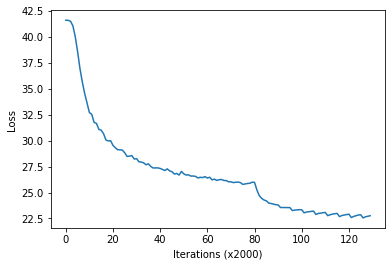

In [6]:
# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size, eval_interval=2000)
trainer.plot()

### 4.3.3 CBOW 모델 평가

In [1]:
import sys
sys.path.append('..')
import pickle
from common.util import most_similar, analogy

In [2]:
pkl_file = './cbow_params.pkl'
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)

In [3]:
word_vecs = params['word_vecs']
word_to_id = params['word_to_id']
id_to_word = params['id_to_word']

In [4]:
# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.6103515625
 someone: 0.59130859375
 i: 0.55419921875
 something: 0.48974609375
 anyone: 0.47314453125

[query] year
 month: 0.71875
 week: 0.65234375
 spring: 0.62744140625
 summer: 0.6259765625
 decade: 0.603515625

[query] car
 luxury: 0.497314453125
 arabia: 0.47802734375
 auto: 0.47119140625
 disk-drive: 0.450927734375
 travel: 0.4091796875

[query] toyota
 ford: 0.55078125
 instrumentation: 0.509765625
 mazda: 0.49365234375
 bethlehem: 0.47509765625
 nissan: 0.474853515625


In [5]:
# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)

--------------------------------------------------

[analogy] king:man = queen:?
 woman: 5.16015625
 veto: 4.9296875
 ounce: 4.69140625
 earthquake: 4.6328125
 successor: 4.609375

[analogy] take:took = go:?
 went: 4.55078125
 points: 4.25
 began: 4.09375
 comes: 3.98046875
 oct.: 3.90625

[analogy] car:cars = child:?
 children: 5.21875
 average: 4.7265625
 yield: 4.20703125
 cattle: 4.1875
 priced: 4.1796875

[analogy] good:better = bad:?
 more: 6.6484375
 less: 6.0625
 rather: 5.21875
 slower: 4.734375
 greater: 4.671875
